<a href="https://colab.research.google.com/github/Klealp/Diplomado_Ciencia_Datos/blob/main/Tareas/Tarea_5_IA_con_Intervalos_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color = red> <center> **Predicción del valor de una acción a 5 días. Sony (LSTM)**

## <font color = blue> Importar las librerías necesarias

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (14, 10)
mpl.rcParams['axes.grid'] = False

print('version de tf: ', tf.__version__)

from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

version de tf:  2.12.0


In [2]:
!pip3 install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## <font color=blue> Lectura de los datos

Estos datos corresponden a la empresa Sony. Son 1311 datos que corresponden a observaciones del precio de la acción, el número de transacciones de la acción (compra-venta). Los datos son diarios (dias hábiles o comerciales) y la ventana de tiempo empieza el 2 de enero de 2018 hasta el 20 de marzo de 2023.

La columna Date es la fecha, Open es el valor de acción a la apertura del mercado, High el valor más alto alcanzado en el día, Low el valor más bajo del día, Close el valor al cierre, Adj Close es el valor al cierre ajustado por divisiones y distribuciones de dividendos y Volume son los volúmenes de acciones transadas en el día.

Los datos se obtuvieron de [Yahoo Finanzas](https://es.finance.yahoo.com/quote/SONY/history?p=SONY).

In [3]:
from pandas_datareader import data as pdr
from datetime import datetime
import yfinance as yf
yf.pdr_override()

tickers = ['SONY'] # Aquí ponen los tickers de las empresas/índices de su interés
inicio = datetime(2018, 1 ,1)
fin = datetime(2023,3,20)
df = pdr.get_data_yahoo(tickers,inicio,fin)

[*********************100%***********************]  1 of 1 completed


In [4]:
# looking at the first five rows of the data
print('\n Shape of the data:')
print(df.shape)
df.head()


 Shape of the data:
(1311, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,45.439999,45.810001,45.240002,45.790001,45.790001,844200
2018-01-03,45.930000,46.360001,45.900002,46.299999,46.299999,612500
2018-01-04,46.810001,47.259998,46.799999,47.250000,47.250000,770600
2018-01-05,48.180000,48.790001,48.169998,48.700001,48.700001,1356100
2018-01-08,48.799999,49.009998,48.730000,49.000000,49.000000,618900


In [5]:
#creating dataframe with date and the target variable
data = pd.DataFrame(df[['Close']])
data.head()

,Close
Date,
2018-01-02,45.790001
2018-01-03,46.299999
2018-01-04,47.250000
2018-01-05,48.700001
2018-01-08,49.000000


## <font color=blue> Visualización de la serie precio de cierre

In [7]:
# plot
len_data = len(data)
len_train = int(len_data*0.8) # 80%  = 1048
len_test = len_data- len_train # 20% = 263
print (len_data, '=', len_train, '+',len_test)

1311 = 1048 + 263


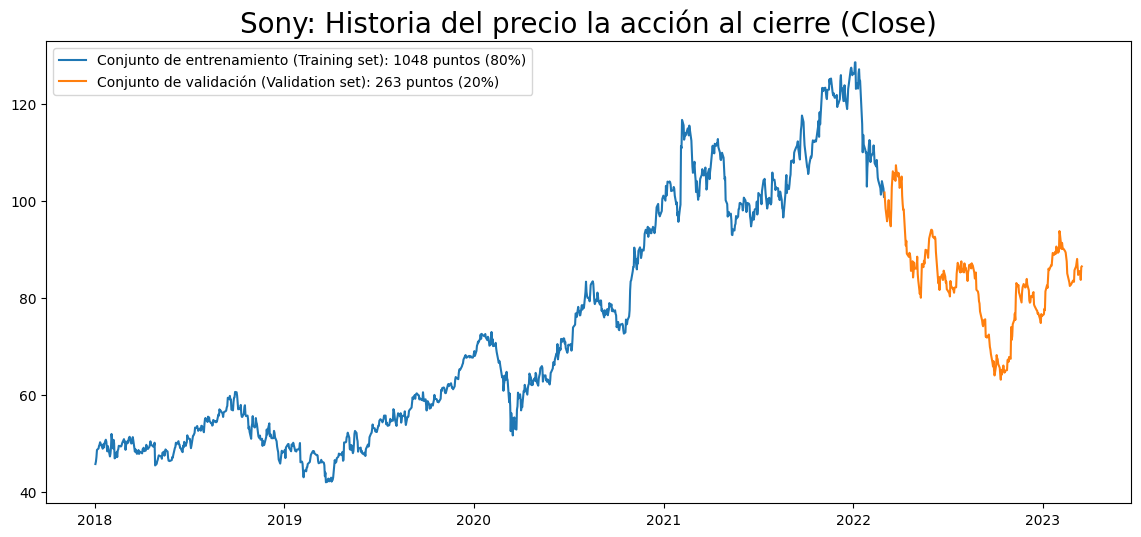

In [8]:
plt.figure(figsize=(14,6))
plt.plot(data[:len_train], label='Conjunto de entrenamiento (Training set): {} puntos (80%)'.format(len_train))
plt.plot(data['Close'][len_train:], label='Conjunto de validación (Validation set): {} puntos (20%)'.format(len_test))
plt.title("Sony: Historia del precio la acción al cierre (Close)", size = 20)
plt.legend()
plt.show()

## <font color = blue> Funciones para Gráficos

In [9]:
def create_time_steps(length):
  return list(range(-length, 0))

In [10]:
def show_plot(plot_data, delta, title):
  labels = ['Historia', 'Futuro Verdadero' , 'Predicción del Modelo']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Salto de tiempo (Time-Step)')
  return plt

In [11]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Pérdida entrenamiento')
    plt.plot(epochs, val_loss, 'r', label='Pérdida validación')
    plt.title(title)
    plt.legend()

    plt.show()

## <font color=blue> Función para preparar datos de entrenamiento

### Caso Multivariado

In [12]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    ''' dataset: conjunto de datos para las secuencias de entrada
        target:  conjunto de datos para las secuencias de salida
        start_index: índice inicial de donde empezar a tomar los datos
        end_index: índice final para tomar los datos. None para tomarlos todos
        history_size: tamaño de la venytana para crear las secuencias
        target_size: dentro de cuántas observaciones futuras desea pronosticar
        step: Cada cuántas observaciones deben tomarse. Para secuencias muy largas
              que no cambia mucho localmente
        single_step: Predecir solamente un valor futuro (=True),
                     o predecir todos los valores hasta target_size(=False)
    '''
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [13]:
TRAIN_SPLIT = len_train
print(TRAIN_SPLIT)

1048


Se debe establecer la semilla para la reproducibilidad

In [14]:
tf.random.set_seed(21)

## <font color=blue> Pronóstico la serie de tiempo multivariada de la acción de SONY

Para realizar el pronóstico de la series del tiempo del valro del cierre de la acción, se decide utilizar solamente las variables de apertura, el valor más alto, y el más bajo, puesto que volumen parece mostrar un comportamiento más diferente a las demás variables, como se aprecia en los siguientes gráficos.

In [15]:
features_considered = ['Open', 'High', 'Low', 'Close','Volume']

In [16]:
features = df[features_considered]
features.head()

,Open,High,Low,Close,Volume
Date,,,,,
2018-01-02,45.439999,45.810001,45.240002,45.790001,844200
2018-01-03,45.930000,46.360001,45.900002,46.299999,612500
2018-01-04,46.810001,47.259998,46.799999,47.250000,770600
2018-01-05,48.180000,48.790001,48.169998,48.700001,1356100
2018-01-08,48.799999,49.009998,48.730000,49.000000,618900


A continuación se aprecia el comportamiento de cada una de las variables en la ventana de tiempo.

<Figure size 1000x400 with 0 Axes>

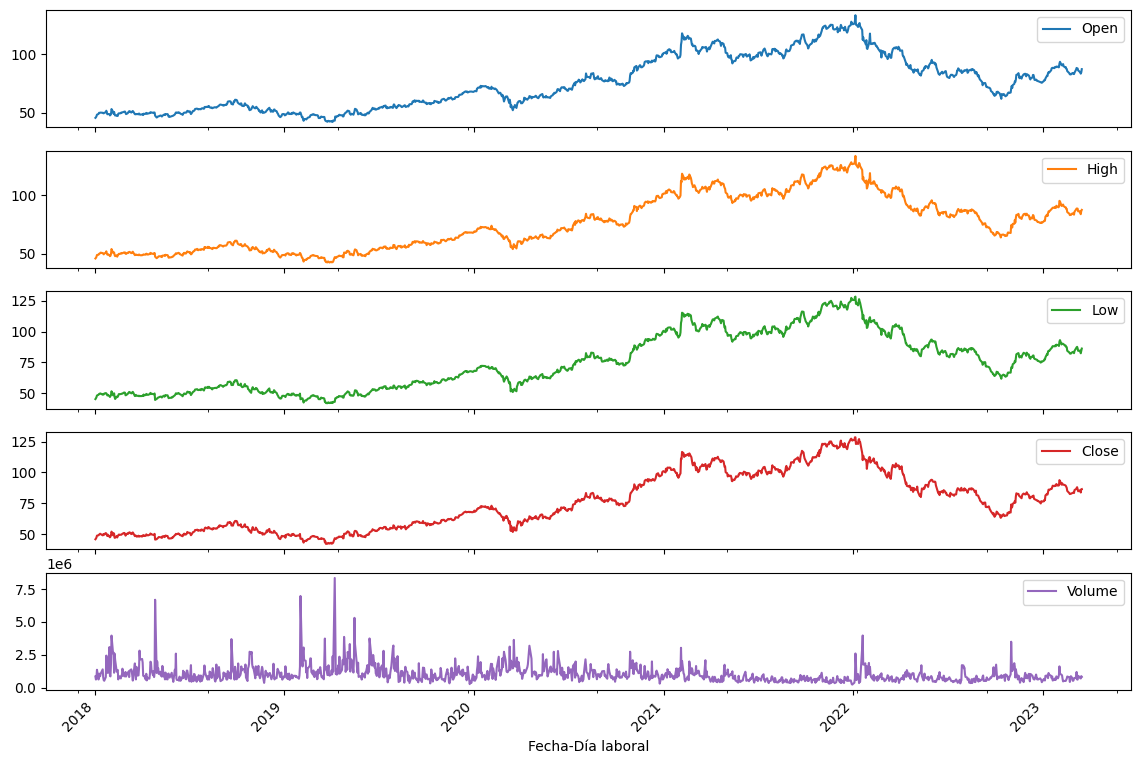

In [17]:
plt.figure(figsize=(10,4))
features.plot(subplots=True, rot=45, xlabel='Fecha-Día laboral')
plt.show()

In [18]:
features_considered = ['Open', 'High', 'Low', 'Close']
features = df[features_considered]

El primer paso será estandarizar el conjunto de datos utilizando la media y la desviación estándar de los datos de entrenamiento, puesto que, aunque las 4 primeras variables se encuentran en la misma escala, esto permitirá un mejor desempeño de las redes neuronales.

In [19]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
print(data_mean, data_std)
dataset

[73.31948481 73.85286255 72.69057251 73.28803426] [24.79569495 24.96224796 24.57195524 24.76581053]


array([[45.43999863, 45.81000137, 45.24000168, 45.79000092],
       [45.93000031, 46.36000061, 45.90000153, 46.29999924],
       [46.81000137, 47.25999832, 46.79999924, 47.25      ],
       ...,
       [83.40000153, 83.76000214, 82.36000061, 83.73999786],
       [84.51000214, 86.47000122, 84.20999908, 86.38999939],
       [87.25      , 87.47000122, 86.18000031, 86.51999664]])

In [20]:
dataset = (dataset-data_mean)/data_std
dataset

array([[-1.12436801, -1.12341089, -1.11715045, -1.11032237],
       [-1.10460645, -1.10137765, -1.09029057, -1.08972953],
       [-1.06911637, -1.06532329, -1.05366354, -1.05137016],
       ...,
       [ 0.40654302,  0.39688491,  0.3935148 ,  0.42203196],
       [ 0.45130888,  0.50544882,  0.46880382,  0.52903438],
       [ 0.56181185,  0.54550931,  0.54897657,  0.53428344]])

## <font color = blue> Modelo a un paso

A continuación se presenta la configuración para hacer la predicción de un único valor 5 días en el futuro, teniendo en cuenta solamente 40 retrasos para cada tiempo. Este código permitirá obtener los arreglos con los datos divididos ene ntrenamiento y validación, separando los retrasos de la variable respuesta en cada fila.

In [21]:
past_history = 40
future_target = 5
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 3], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 3],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [22]:
print(dataset.shape)
print(x_train_single.shape)
print(y_train_single.shape)
print(x_val_single.shape)
print(y_val_single.shape)

(1311, 4)
(1008, 40, 4)
(1008,)
(218, 40, 4)
(218,)


Acá se ve un ejemplo de una ventana de datos de la historia pasada

In [23]:
print ('Ventana ejemplo de la historia pasada : {}'.format(x_train_single[0].shape))

Ventana ejemplo de la historia pasada : (40, 4)


### Crear objetos tf.data.Dataset

In [24]:
BATCH_SIZE = 50
BUFFER_SIZE = 1000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

## <font color=blue> Crear el modelo LSTM

In [25]:
# shapes
input_shape = (x_train_single.shape[1], x_train_single.shape[2])
units = 64
drop_out = 0.4

# layers
inputs = Input(input_shape)
x = Dropout(drop_out, name= 'Dropout_01')(inputs)
x = Bidirectional(LSTM(units=units, name='LSTM_layer'))(x)
x = Dropout(drop_out, name= 'Dropout_02')(x)
x = LSTM(units=units, return_sequences=True,name='LSTM_layer')(inputs)
x = Dropout(drop_out, name= 'Dropout_03')(x)
x = LSTM(units=units//2, name='LSTM_layer_2')(x)
x = Dropout(drop_out, name= 'Dropout_04')(x)
outputs = Dense(1)(x)

# model
single_step_model = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')
single_step_model.summary()

Model: "series_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 4)]           0         
                                                                 
 LSTM_layer (LSTM)           (None, 40, 64)            17664     
                                                                 
 Dropout_03 (Dropout)        (None, 40, 64)            0         
                                                                 
 LSTM_layer_2 (LSTM)         (None, 32)                12416     
                                                                 
 Dropout_04 (Dropout)        (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,113
Trainable params: 30,113
Non

### Compila

In [26]:
single_step_model.compile(loss='mean_squared_error',optimizer=Adam())

### Entrenar el modelo

Para entrenar el modelo se deciden utilizar 15 épocas conn un intervalo de evaluación de 80

In [27]:
EVALUATION_INTERVAL = 80
EPOCHS = 15
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=5)

Epoch 1/15
80/80 [==============================] - 10s 57ms/step - loss: 0.1088 - val_loss: 0.0671
Epoch 2/15
80/80 [==============================] - 4s 51ms/step - loss: 0.0602 - val_loss: 0.0575
Epoch 3/15
80/80 [==============================] - 5s 62ms/step - loss: 0.0579 - val_loss: 0.0503
Epoch 4/15
80/80 [==============================] - 4s 46ms/step - loss: 0.0541 - val_loss: 0.0429
Epoch 5/15
80/80 [==============================] - 4s 46ms/step - loss: 0.0513 - val_loss: 0.0502
Epoch 6/15
80/80 [==============================] - 6s 70ms/step - loss: 0.0485 - val_loss: 0.0460
Epoch 7/15
80/80 [==============================] - 4s 46ms/step - loss: 0.0468 - val_loss: 0.0514
Epoch 8/15
80/80 [==============================] - 4s 46ms/step - loss: 0.0481 - val_loss: 0.0498
Epoch 9/15
80/80 [==============================] - 5s 58ms/step - loss: 0.0463 - val_loss: 0.0394
Epoch 10/15
80/80 [==============================] - 5s 57ms/step - loss: 0.0472 - val_loss: 0.0429
Epoch 11

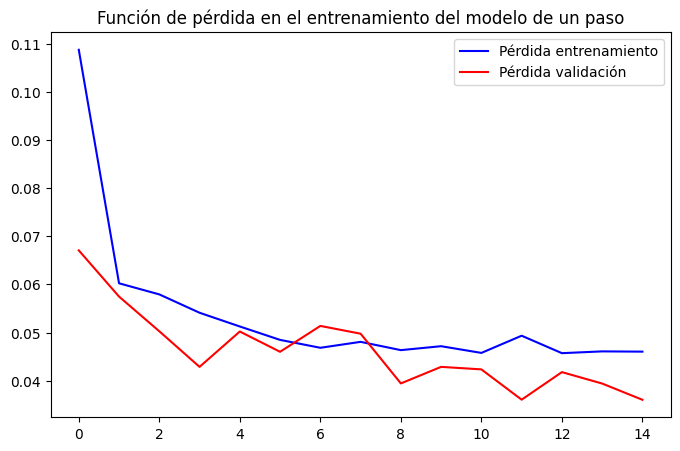

In [28]:
mpl.rcParams['figure.figsize'] = (8, 5)
plot_train_history(single_step_history,
                   'Función de pérdida en el entrenamiento del modelo de un paso')

## <font color=blue> Predicciones

Se pueden apreciar dos ejemplos escogidos aleatoriamente que muestra las comparaciones entre el valor verdadero y el predicho por el modelo.

2/2 [==============================] - 1s 13ms/step


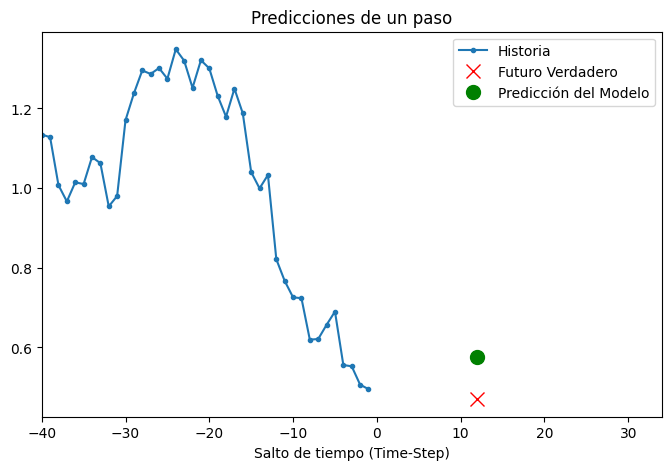

2/2 [==============================] - 0s 13ms/step


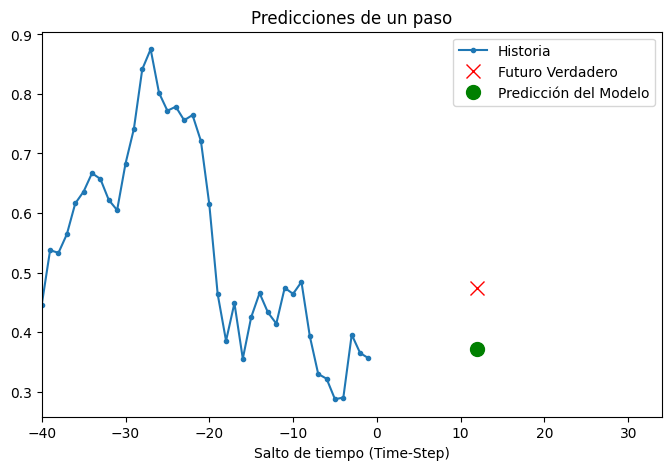

2/2 [==============================] - 0s 13ms/step


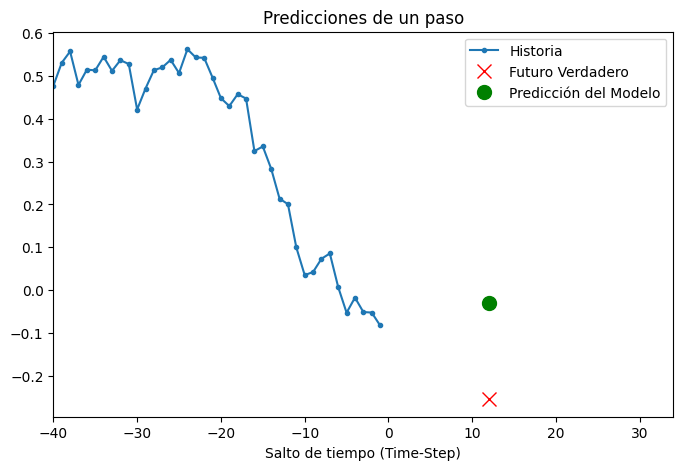

In [29]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Predicciones de un paso')
    plot.show()

In [30]:
y_pred = single_step_model.predict(x_val_single)
y_pred = np.squeeze(y_pred,axis=1)
y_test = y_val_single

print(y_pred.shape)
print(y_test.shape)

7/7 [==============================] - 1s 13ms/step
(218,)
(218,)


### RMS

Se tiene que el error cuadrático medio sobre los datos escalados es de aproximadamente 0.19, el cual no parece ser muy alto.

In [31]:
rmsLSTM = np.sqrt(np.mean(np.power(y_pred-y_test,2)))
print(rmsLSTM )

0.1898085477587698


In [32]:
def plot_series(y_test,y_pred, title, x_label, y_label,rms,epochs):
    plt.plot(np.arange(0, len(y_test)), y_test, marker='.', label="verdadero")
    plt.plot(np.arange(0, len(y_test)), y_pred, marker='+', label="predicho")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.annotate("rms="+str(round(rms,2)) , xy=(500, 1.3), size = 10)
    #plt.annotate("modelo = LSTM(50), timestep=60" , xy=(100, 146), size = 15)
    #
    plt.annotate("epochs="+str(epochs) , xy=(500, 1.5), size = 10)
    plt.title(title)
    plt.legend()
    plt.show()


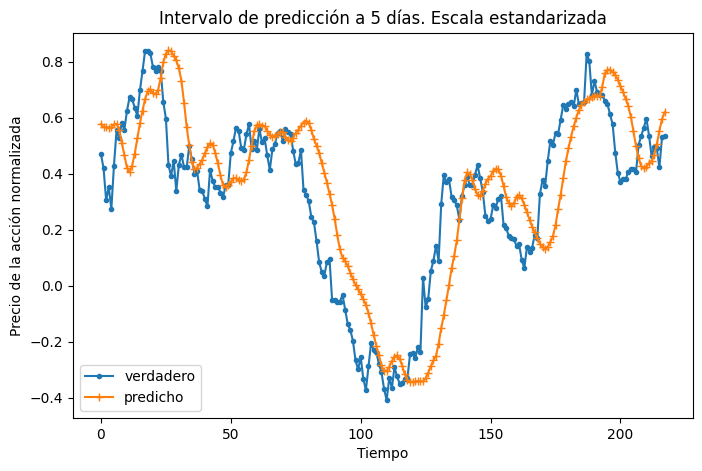

In [33]:
title = "Intervalo de predicción a 5 días. Escala estandarizada"
x_label = 'Tiempo'
y_label = 'Precio de la acción normalizada'
rms = rmsLSTM
plot_series(y_test, y_pred,title,x_label, y_label, rms,epochs=10 )

## <font color=blue> Regreso a la escala original

In [34]:
y_pred_or1 = (y_pred*data_std[3])+data_mean[3]
y_test_or1 = (y_test*data_std[3])+data_mean[3]

### RMS sobre la escala original

Ahora el error cuadrático medio sobre la escala original de las acciones es de 4.70, que nuevamente no resalta por ser un valor alto.

In [35]:
rmsLSTM = np.sqrt(np.mean(np.power(y_pred_or1-y_test_or1,2)))
print(rmsLSTM )

4.7007623227861215


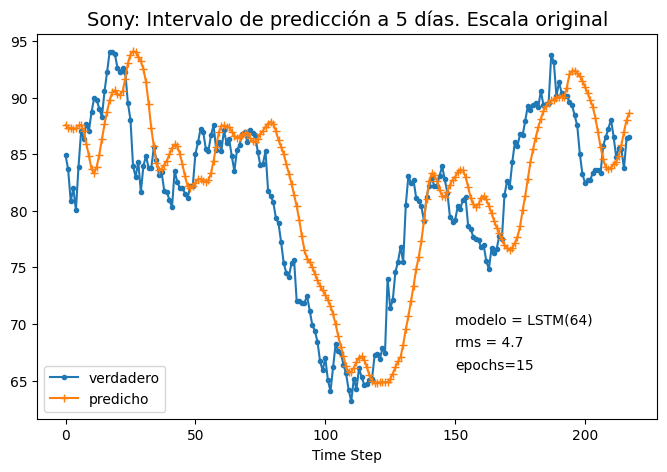

In [40]:
plt.plot(np.arange(0, len(y_test_or1)), y_test_or1, marker='.', label="verdadero")
plt.plot(np.arange(0, len(y_test_or1)), y_pred_or1, marker='+', label="predicho")
plt.xlabel('Time Step')
plt.annotate("rms = "+str(round(rmsLSTM,2)) , xy=(150, 68), size = 10)
plt.annotate("modelo = LSTM(64)" , xy=(150, 70), size = 10)
plt.annotate("epochs=15" , xy=(150, 66), size = 10)
plt.title("Sony: Intervalo de predicción a 5 días. Escala original", size = 14)
plt.legend()
plt.show();

## <font color = blue> Intervalos de Predicción con Regresión Cuantílica

Se estima un intervalo de predicción del 80% para los siguientes 5 días utilizando la estrategia de regresión por cuantiles. En este ejemplo, se entrena un modelo de gradient boosting LightGBM, sin embargo, el lector puede utilizar cualquier otro modelo simplemente reemplazando la definición del regresor.

In [41]:
pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0


In [42]:
# Modelado y Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.metrics import mean_pinball_loss

# Configuración
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [43]:
# Crear forecasters: uno para cada límite del intervalo
# ==============================================================================
# Los forecasters obtenidos para alpha=0.1 y alpha=0.9 producen un intervalo de
# confianza del 80% (90% - 10% = 80%).

# Forecaster para cuantil 10%
forecaster_q10 = ForecasterAutoregDirect(
                     regressor = LGBMRegressor(
                                     objective     = 'quantile',
                                     metric        = 'quantile',
                                     alpha         = 0.05,
                                     learning_rate = 0.1,
                                     max_depth     = 10,
                                     n_estimators  = 100,
                                     random_state  = 123
                                 ),
                     lags = 40,
                     steps = 5
                 )

# Forecaster para cuantil 90%
forecaster_q90 = ForecasterAutoregDirect(
                     regressor = LGBMRegressor(
                                     objective     = 'quantile',
                                     metric        = 'quantile',
                                     alpha         = 0.95,
                                     learning_rate = 0.1,
                                     max_depth     = 10,
                                     n_estimators  = 100,
                                     random_state  = 123
                                 ),
                     lags = 40,
                     steps = 5
                 )

Al validar un modelo de regresión por cuantiles, se debe proporcionar una métrica personalizada según el cuantil que se esté estimando. Estas mismas métricas se volverán a utilizar al ajustar los hiperparámetros de cada modelo.

In [44]:
# Función de coste para cada cuantil (pinball_loss)
# ==============================================================================
def mean_pinball_loss_q10(y_true, y_pred):
    """
    Pinball loss for quantile 10.
    """
    return mean_pinball_loss(y_true, y_pred, alpha=0.1)


def mean_pinball_loss_q90(y_true, y_pred):
    """
    Pinball loss for quantile 90.
    """
    return mean_pinball_loss(y_true, y_pred, alpha=0.9)

### Búsqueda de los Hiperparámetros

In [59]:
# Grid search para los hyper-parámetros y lags de cada quantile-forecaster
# ==============================================================================
# Hyper-parametros del regresor
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1]
}

# Lags utilizados como predictores
lags_grid = [40]

results_grid_q10 = grid_search_forecaster(
                       forecaster         = forecaster_q10,
                       y                  = features.iloc[:, 3].reset_index(drop=True),
                       param_grid         = param_grid,
                       lags_grid          = lags_grid,
                       steps              = 5,
                       refit              = False,
                       metric             = mean_pinball_loss_q10,
                       initial_train_size = len_train,
                       fixed_train_size   = False,
                       return_best        = True,
                       verbose            = False
                   )

results_grid_q90 = grid_search_forecaster(
                       forecaster         = forecaster_q90,
                       y                  = features.iloc[:, 3].reset_index(drop=True),
                       param_grid         = param_grid,
                       lags_grid          = lags_grid,
                       steps              = 5,
                       refit              = False,
                       metric             = mean_pinball_loss_q90,
                       initial_train_size = len_train,
                       fixed_train_size   = False,
                       return_best        = True,
                       verbose            = False
                   )

Number of models compared: 18.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/18 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 100}
  Backtesting metric: 0.8475952617283641

Number of models compared: 18.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/18 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 500}
  Backtesting metric: 0.807238472279163



In [61]:
# Backtesting con datos de test
# ==============================================================================
# el ejemplo tenía train, val y test, como acá solo hay train y val el initial_train_size va solo con len_train
metric_q10, predictions_q10 = backtesting_forecaster(
                                  forecaster         = forecaster_q10,
                                  y                  = features['Close'].reset_index(drop=True),
                                  initial_train_size = len_train,
                                  fixed_train_size   = False,
                                  steps              = 5,
                                  refit              = False,
                                  metric             = mean_pinball_loss_q10,
                                  verbose            = False
                              )

metric_q90, predictions_q90 = backtesting_forecaster(
                                  forecaster         = forecaster_q90,
                                  y                  = features['Close'].reset_index(drop=True),
                                  initial_train_size = len_train,
                                  fixed_train_size   = False,
                                  steps              = 5,
                                  refit              = False,
                                  metric             = mean_pinball_loss_q90,
                                  verbose            = False
                              )

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

In [62]:
# Cobertura del intervalo en los datos de test
# ==============================================================================
inside_interval = np.where(
                      (features.iloc[len_train:,3].reset_index(drop=True) >= predictions_q10.reset_index(drop=True)['pred']) & \
                      (features.iloc[len_train:,3].reset_index(drop=True) <= predictions_q90.reset_index(drop=True)['pred']),
                      True,
                      False
                  )

coverage = inside_interval.mean()
print(f"Cobertura del intervalo predicho con los datos de test: {100 * coverage}")

Cobertura del intervalo predicho con los datos de test: 68.06083650190115


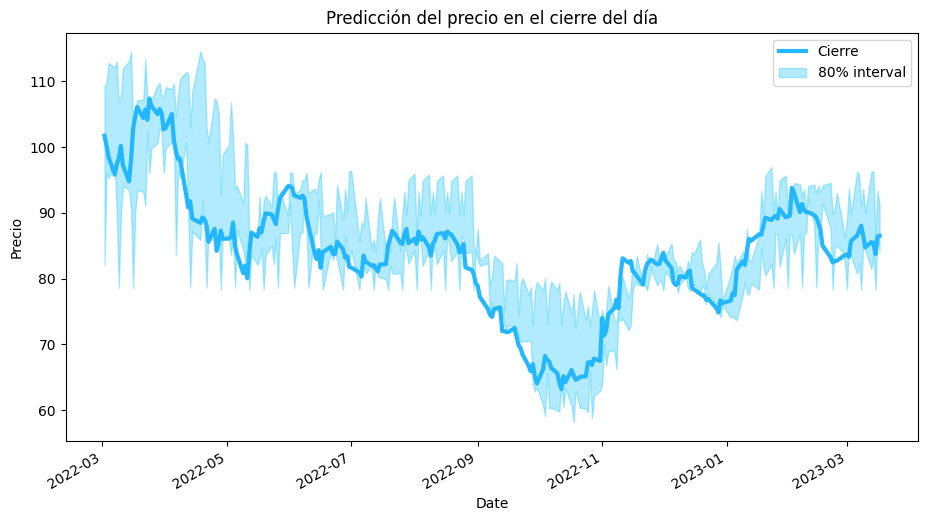

In [63]:
# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(11, 6))
features.iloc[len_train:, 3].plot(ax=ax, label='Cierre', linewidth=3, color="#23b7ff")
ax.fill_between(
    features.iloc[len_train:].index,
    predictions_q10['pred'],
    predictions_q90['pred'],
    color = 'deepskyblue',
    alpha = 0.3,
    label = '80% interval'
)
ax.set_ylabel('Precio')
ax.set_title('Predicción del precio en el cierre del día')
ax.legend();